In [13]:
#导入库
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 

In [14]:
#路径设置
os.chdir(r'D:\编程\线上实习Python\课程配套数据')
os.getcwd()

'D:\\编程\\线上实习Python\\课程配套数据'

In [23]:
#读入数据
data_detail = pd.read_csv('meal_order_detail.csv')
data_info = pd.read_csv('meal_order_info.csv',encoding='unicode_escape')
print(data_detail.columns,data_info.columns)

Index(['detail_id', 'order_id', 'dishes_id', 'logicprn_name',
       'parent_class_name', 'dishes_name', 'itemis_add', 'counts', 'amounts',
       'cost', 'place_order_time', 'discount_amt', 'discount_reason',
       'kick_back', 'add_inprice', 'add_info', 'bar_code', 'picture_file',
       'emp_id'],
      dtype='object') Index(['info_id', 'emp_id', 'number_consumers', 'mode', 'dining_table_id',
       'dining_table_name', 'expenditure', 'dishes_count', 'accounts_payable',
       'use_start_time', 'check_closed', 'lock_time', 'cashier_id', 'pc_id',
       'order_number', 'org_id', 'print_doc_bill_num', 'lock_table_info',
       'order_status', 'phone', 'name'],
      dtype='object')


In [25]:
#米饭删除
data_detail = data_detail.drop(index=(data_detail.loc[(data_detail['dishes_name']=='白饭/小碗')].index))
data_detail = data_detail.drop(index=(data_detail.loc[(data_detail['dishes_name']=='白饭/大碗')].index))

#菜品字符名称处理
data_detail.dishes_name = data_detail.dishes_name.str.strip()

In [42]:
#菜品销量
res = data_detail.groupby('dishes_name')['counts'].sum()

#菜品热销度
res_new = (res-res.min())/(res.max()-res.min())

#排序
res_new_sort = res_new.sort_values(ascending=False)[:10]

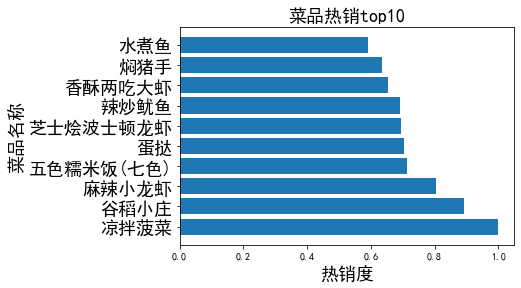

In [18]:
#菜品热销top10绘图
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
y =list(res_new_sort.values)
x = ['凉拌菠菜','谷稻小庄','麻辣小龙虾','五色糯米饭(七色)','蛋挞','芝士烩波士顿龙虾','辣炒鱿鱼','香酥两吃大虾','焖猪手','水煮鱼']
plt.barh(x,y)
plt.yticks(fontsize=18)
plt.xlabel('热销度',fontsize=18)
plt.ylabel('菜品名称',fontsize=18)
plt.title('菜品热销top10',fontsize=18)
plt.show()
#plt.savefig('菜品热销top10条形图.jpg')

In [43]:
#统计订单状态占比
data_status = data_info.groupby('order_status')['order_status'].count()
data_status_new = data_status / (len(data_info))
data_status_new

order_status
0    0.009524
1    0.987302
2    0.003175
Name: order_status, dtype: float64

In [44]:
#选取有效订单数据
data_info_effect = data_info[data_info['order_status']==1]
data_wash = pd.merge(data_info_effect,data_detail,left_on='info_id',right_on='order_id')
data_effect = data_wash[['dishes_name','emp_id_y']]

In [45]:
#删除三个菜及以下的客户
data_count = data_effect.groupby('emp_id_y')['dishes_name'].count()  #分组聚合统计每个客户id对应的点菜数量
data_count_effect = data_count[data_count.values > 3]
data_effect1 = pd.merge(data_effect,data_count_effect,left_on='emp_id_y',right_on='emp_id_y')
data_effect_final =data_effect1[['emp_id_y','dishes_name_x']]  #仅保留有用的客户id emp_id 和菜品名称dishes_name
data_effect_final.columns = ['emp_id','dishes_name']  #列名重命名

In [46]:
#通过客户id划分测试集训练集客户id
train_empid = []
test_empid = []
np.random.seed(4) #种子
for i in data_count.index:
    if np.random.randint(1,11) > 3: #大于3为训练集小于3位测试集，分别占70%和30%
        train_empid.append(i)
    else:
        test_empid.append(i)

In [47]:
#print('训练集客户id',train_empid,len(train_empid))
#print('测试集客户id',test_empid,len(test_empid))

In [48]:
#测试集训练集划分 
data_train = data_effect_final
data_test = data_effect_final
for i in test_empid:     #删除测试集客户id索引数据，剩下训练集数据
    data_train = data_train.drop(index=(data_train.loc[(data_train['emp_id']==i)].index))
for j in train_empid:    #删除训练集客户id索引数据，剩下测试集数据
    data_test = data_test.drop(index=(data_test.loc[(data_test['emp_id']==j)].index))

In [49]:
#构建训练集客户id-菜品二元矩阵
data_train['dishes']=1
data_train_matrix = data_train.pivot_table(index='emp_id',columns='dishes_name',values='dishes',aggfunc=np.mean)
data_train_matrix.fillna(0,inplace=True) #用0替代空值

In [50]:
#构建菜品-菜品二元矩阵 内为空值
dishes_names=data_train_matrix.columns.tolist()[0:]
dishes_similar = pd.DataFrame(index=dishes_names,columns=dishes_names)

In [51]:
#定义菜品相似度计算 （Jaccard相似度）
def similarity(j,k):
    n_both = len(data_train_matrix[(data_train_matrix[j]==1)&(data_train_matrix[k]==1)]) #同时点了j和k两个菜品的客户数量
    n = len(data_train_matrix[(data_train_matrix[j]==1)|(data_train_matrix[k]==1)]) #仅点了j或者k菜品的客户数量
    q = n_both/n
    return q

In [52]:
#构建训练集菜品相似度二维矩阵
for j in dishes_similar.columns:
    for k in dishes_similar.columns:
        dishes_similar.loc[j,k]=similarity(j,k) #循环较久

In [53]:
#将训练集菜品相似度矩阵输出保存
dishes_similar.to_csv('训练集菜品相似度矩阵.csv')

#读取训练集菜品相似度矩阵
#dishes_similar = pd.read_csv('训练集菜品相似度矩阵.csv')

In [54]:
#构建测试集客户id和菜品二维矩阵
data_test['dishes']=1
data_test_matrix = data_test.pivot_table(index='emp_id',columns='dishes_name',values='dishes',aggfunc=np.mean)
data_test_matrix.fillna(0,inplace=True) #用0替代空值

In [55]:
#将测试集客户id和菜品二维矩阵输出保存
data_test_matrix.to_csv('测试集客户id菜品二维矩阵')

#读取测试集客户id和菜品二维矩阵
data_test_martix = pd.read_csv('测试集客户id菜品二维矩阵')

In [56]:
#构建测试集客户对菜品的感兴趣程度表 (P=SIM*R)
data_test_interest = np.dot(data_test_matrix,dishes_similar)
data_test_interest =pd.DataFrame(data_test_interest,columns=(data_test_matrix.columns),index=(data_test_matrix.index))

#将测试集客户对菜品的兴趣程度输出保存
data_test_interest.to_csv('测试集客户对菜品的兴趣程度')

In [58]:
#测试集客户id对应已点菜品字典
data_test_dishes = {}
for i in data_test_matrix.index:
    j = data_test_matrix.loc[i,data_test_matrix.loc[i]==1].index.tolist()
    data_test_dishes[i] = j

In [165]:
#测试集中客户对于菜品感兴趣程度推荐列表TOP10  
data_interest_top10 = {} #data_interest_top10为客户id对应的推菜品字典（前top10）
for i,j in enumerate(data_test_interest.index): 
    a = data_test_interest.sort_values(by=j,ascending=False,axis=1).columns[:10].tolist()
    data_interest_top10[j]=a

In [166]:
#定义单个客户推荐准确精度函数accuracy(x)
def accuracy(x):
    n=0  #n为正确匹配客户已点菜品数目
    for i in data_interest_top10[x]:
            if i in data_test_dishes[x]:
                n=n+1
    return n/10

In [167]:
#每个客户的推荐精确度
data_accuracy=[]
for i in data_test_interest.index:
    a = accuracy(i)
    data_accuracy.append(a)

In [168]:
#推荐准确度分析
data_accuracy_mean = np.mean(data_accuracy)
data_accuracy_median = np.median(data_accuracy)
data_accuracy_max = np.max(data_accuracy)
data_accuracy_min = np.min(data_accuracy)
print('推荐客户菜品准确度均值为:',str(data_accuracy_mean*100),'%')
print('推荐客户菜品准确度中位数为:',str(data_accuracy_median*100),'%')
print('推荐客户菜品准确度最大值为:',str(data_accuracy_max*100),'%')
print('推荐客户菜品准确度最小值为:',str(data_accuracy_min*100),'%')

推荐客户菜品准确度均值为: 51.64122137404581 %
推荐客户菜品准确度中位数为: 50.0 %
推荐客户菜品准确度最大值为: 95.0 %
推荐客户菜品准确度最小值为: 20.0 %
